# Probabilistic Damage Classification with a Bayesian Neural Network (BNN)
The model will not only provide a classification but also quantify its own uncertainty for each prediction.

# Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import entropy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Dataset and Dataloaders

In [4]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'Concrete Crack Images for Classification'

if not os.path.exists(data_dir):
    print(f"Error: Dataset path '{data_dir}' does not exist.")
    print("Please update the 'data_dir' variable.")
else:
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers = 0)
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    print(f"Classes: {class_names}")

Classes: ['Cracked', 'Intact']


# Transfer Learning using ResNet18

In [5]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout layer for uncertainty
    nn.Linear(256, len(class_names))
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\kissi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


c:\Users\kissi\anaconda3\envs\cuda_pt\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kissi\anaconda3\envs\cuda_pt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [01:04<00:00, 728kB/s] 


# Training Loop

In [6]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 5 

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

Epoch 1/5
----------


Train Phase: 100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


Train Loss: 0.1789 Acc: 0.9305


Val Phase: 100%|██████████| 250/250 [01:17<00:00,  3.22it/s]


Val Loss: 0.0188 Acc: 0.9961
Epoch 2/5
----------


Train Phase: 100%|██████████| 1000/1000 [01:43<00:00,  9.65it/s]


Train Loss: 0.1503 Acc: 0.9427


Val Phase: 100%|██████████| 250/250 [00:26<00:00,  9.47it/s]


Val Loss: 0.0216 Acc: 0.9964
Epoch 3/5
----------


Train Phase: 100%|██████████| 1000/1000 [01:44<00:00,  9.59it/s]


Train Loss: 0.1404 Acc: 0.9467


Val Phase: 100%|██████████| 250/250 [00:25<00:00,  9.67it/s]


Val Loss: 0.0152 Acc: 0.9950
Epoch 4/5
----------


Train Phase: 100%|██████████| 1000/1000 [01:43<00:00,  9.69it/s]


Train Loss: 0.1372 Acc: 0.9479


Val Phase: 100%|██████████| 250/250 [00:25<00:00,  9.76it/s]


Val Loss: 0.0221 Acc: 0.9942
Epoch 5/5
----------


Train Phase: 100%|██████████| 1000/1000 [01:43<00:00,  9.65it/s]


Train Loss: 0.1326 Acc: 0.9492


Val Phase: 100%|██████████| 250/250 [00:25<00:00,  9.70it/s]

Val Loss: 0.0118 Acc: 0.9965


# Evaluation with Monte Carlo Dropout

In [7]:
def predictive_entropy(mc_outputs):
    mean_preds = np.mean(mc_outputs, axis=0)
    return entropy(mean_preds.T)

def mutual_information(mc_outputs):

    # Predictive Entropy
    p_entropy = predictive_entropy(mc_outputs)
    
    # Expected Entropy
    expected_entropy = np.mean(entropy(mc_outputs.transpose(0, 2, 1)), axis=0)
    return p_entropy - expected_entropy

def evaluate_with_uncertainty(model, dataloader, num_mc_samples=50):
    model.train() # Activate dropout layers for MC inference
    all_labels = []
    all_mean_preds = []
    all_pred_entropies = []
    all_mutual_infos = []
    all_inputs = []

    for inputs, labels in tqdm(dataloader, desc="Evaluating with Uncertainty"):
        inputs = inputs.to(device)
        mc_outputs = []
        with torch.no_grad():
            for _ in range(num_mc_samples):
                mc_outputs.append(torch.nn.functional.softmax(model(inputs), dim=1))
            
            mc_outputs = torch.stack(mc_outputs).cpu().numpy()
            mean_preds = mc_outputs.mean(axis=0)
            
            pred_entropy_batch = predictive_entropy(mc_outputs)
            mut_info_batch = mutual_information(mc_outputs)

            all_labels.extend(labels.cpu().numpy())
            all_mean_preds.extend(mean_preds)
            all_pred_entropies.extend(pred_entropy_batch)
            all_mutual_infos.extend(mut_info_batch)
            
            inv_normalize = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            )
            for i in range(inputs.size(0)):
                all_inputs.append(inv_normalize(inputs[i]).cpu())

    return np.array(all_labels), np.array(all_mean_preds), np.array(all_pred_entropies), np.array(all_mutual_infos), all_inputs

# Run evaluation on the validation set
labels, mean_preds, entropies, mutual_infos, images = evaluate_with_uncertainty(model, dataloaders['val'])
predicted_classes = np.argmax(mean_preds, axis=1)

accuracy = accuracy_score(labels, predicted_classes)
f1 = f1_score(labels, predicted_classes)

print(f"\nOverall Model Accuracy: {accuracy:.4f}")
print(f"Overall Model F1-Score: {f1:.4f}")

Evaluating with Uncertainty: 100%|██████████| 250/250 [03:35<00:00,  1.16it/s]


Overall Model Accuracy: 0.9914
Overall Model F1-Score: 0.9914


# Uncertainty Visualization

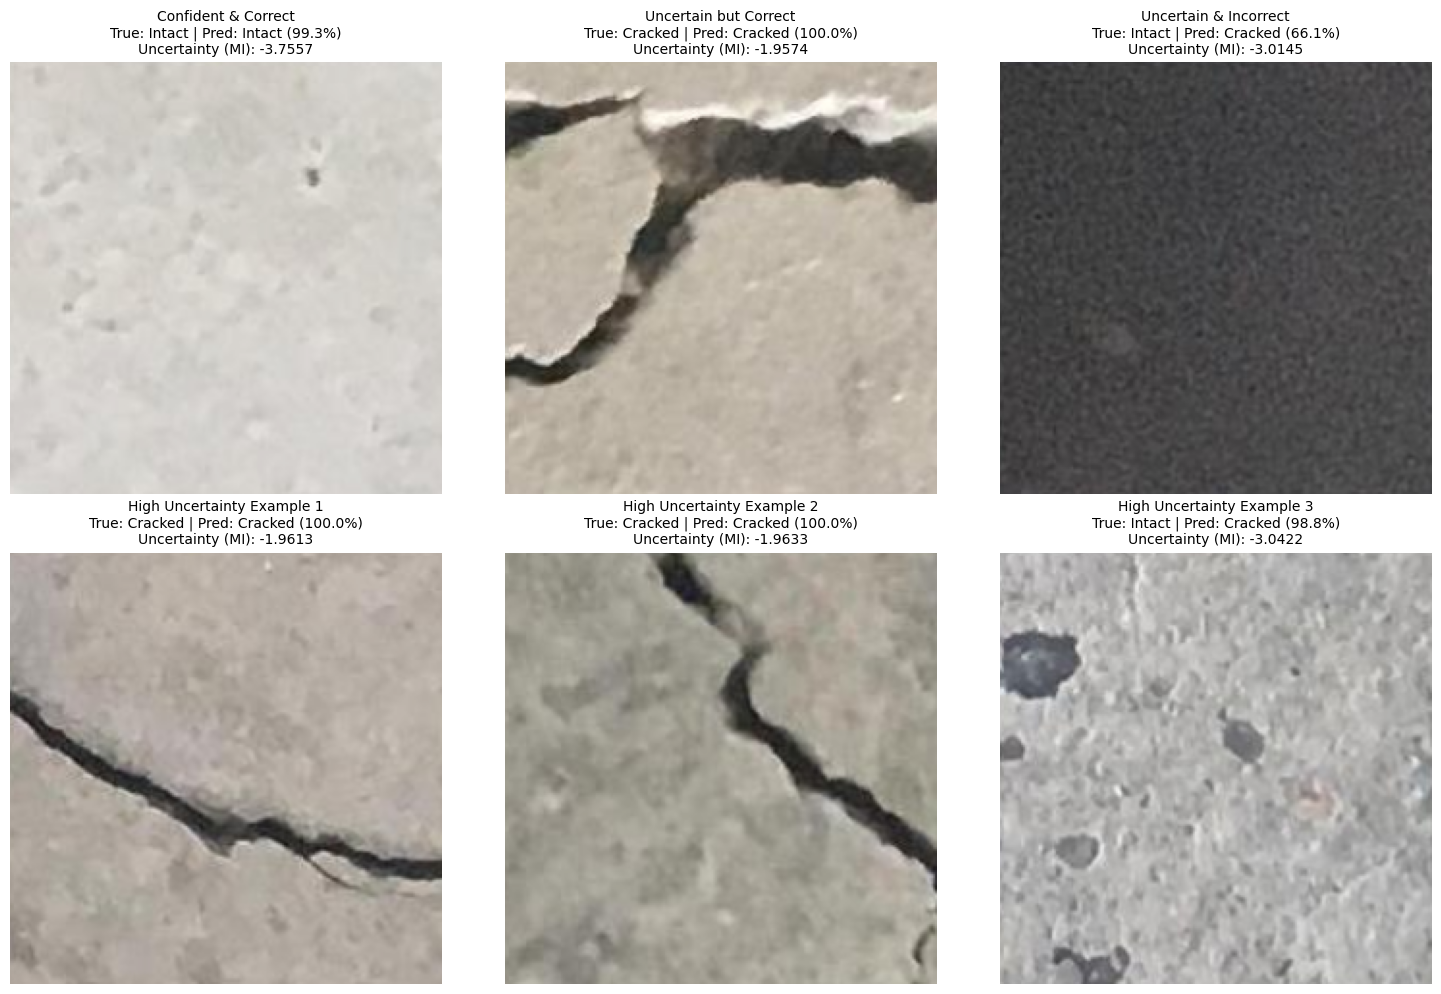

In [11]:
correct_indices = np.where(predicted_classes == labels)[0]
incorrect_indices = np.where(predicted_classes != labels)[0]

# Sort by uncertainty (mutual information)
sorted_correct_by_mi = correct_indices[np.argsort(-mutual_infos[correct_indices])] # High to low
sorted_incorrect_by_mi = incorrect_indices[np.argsort(-mutual_infos[incorrect_indices])]

def show_image_with_info(idx, title):
    plt.imshow(images[idx].permute(1, 2, 0))
    pred_class = class_names[predicted_classes[idx]]
    true_class = class_names[labels[idx]]
    confidence = np.max(mean_preds[idx]) * 100
    mi = mutual_infos[idx]
    
    plt.title(f"{title}\nTrue: {true_class} | Pred: {pred_class} ({confidence:.1f}%)\nUncertainty (MI): {mi:.4f}", fontsize=10)
    plt.axis('off')

plt.figure(figsize=(15, 10))

# 1. Most confident correct prediction (low uncertainty)
plt.subplot(2, 3, 1)
most_confident_idx = sorted_correct_by_mi[-1] # Last one is lowest MI
show_image_with_info(most_confident_idx, "Confident & Correct")

# 2. Least confident correct prediction (high uncertainty)
plt.subplot(2, 3, 2)
least_confident_idx = sorted_correct_by_mi[0]
show_image_with_info(least_confident_idx, "Uncertain but Correct")

# 3. Most uncertain incorrect prediction
plt.subplot(2, 3, 3)
if len(sorted_incorrect_by_mi) > 0:
    most_uncertain_incorrect_idx = sorted_incorrect_by_mi[0]
    show_image_with_info(most_uncertain_incorrect_idx, "Uncertain & Incorrect")
else:
    plt.title("No Incorrect Predictions")
    plt.axis('off')

# 4, 5, 6. More high-uncertainty examples
plt.subplot(2, 3, 4)
show_image_with_info(sorted_correct_by_mi[1], "High Uncertainty Example 1")
plt.subplot(2, 3, 5)
show_image_with_info(sorted_correct_by_mi[2], "High Uncertainty Example 2")
plt.subplot(2, 3, 6)
if len(sorted_incorrect_by_mi) > 1:
    show_image_with_info(sorted_incorrect_by_mi[1], "High Uncertainty Example 3")
else:
    plt.title("Not Enough Incorrect Examples")
    plt.axis('off')

plt.tight_layout()
plt.savefig('bnn_crack_classifier_results.png', dpi=300)
plt.show()